<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: kNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import pathlib
import random
from statistics import mode, StatisticsError
import timeit

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [3]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz

data_root_orig = tf.keras.utils.get_file('new_pic',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/new_pic/Guillaume_Loranchet
/root/.keras/datasets/new_pic/.DS_Store


In [4]:
data_root_orig_1 = tf.keras.utils.get_file('new_pic(1)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(1).tar.gz',
                                         untar=True)
data_root_1 = pathlib.Path(data_root_orig_1)
for item in data_root_1.iterdir():
  print(item)

/root/.keras/datasets/new_pic(1)/.DS_Store
/root/.keras/datasets/new_pic(1)/Guillaume_Paya
/root/.keras/datasets/new_pic(1)/Miha_S


In [5]:
data_root_orig_2 = tf.keras.utils.get_file('new_pic(2)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(2).tar.gz',
                                         untar=True)
data_root_2 = pathlib.Path(data_root_orig_2)
for item in data_root_2.iterdir():
  print(item)

/root/.keras/datasets/new_pic(2)/.DS_Store
/root/.keras/datasets/new_pic(2)/Nicholas_S


In [0]:
data_root_orig_test = tf.keras.utils.get_file('result',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/result.tar.gz',
                                         untar=True)
data_root_test = pathlib.Path(data_root_orig_test)
for item in data_root_test.iterdir():
  print(item)

##Inspect the dataset

In [0]:
all_image_paths_0 = list(data_root.glob('*/*'))
all_image_paths_1 = list(data_root_1.glob('*/*'))
all_image_paths_2 = list(data_root_2.glob('*/*'))

all_image_paths = all_image_paths_2 + all_image_paths_1 + all_image_paths_0

all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [7]:
all_image_paths[:5]

['/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_54_rot_clock_0.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_19_sp_1_rot_clock_0.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_17_sharpened_1_5.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_4_sp_7.png',
 '/root/.keras/datasets/new_pic(1)/Guillaume_Paya/Guillaume_Paya_30_sp_5_rot_anty_1.png']

###Show images

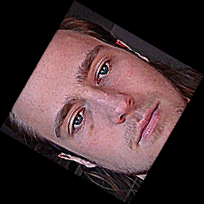

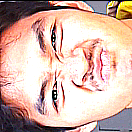

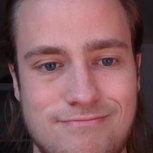

In [8]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [9]:
label_names_0 = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names_1 = sorted(item.name for item in data_root_1.glob('*/') if item.is_dir())
label_names_2 = sorted(item.name for item in data_root_2.glob('*/') if item.is_dir())

label_names = label_names_0 + label_names_1 + label_names_2
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [10]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 2, 0, 0, 1, 0, 2, 3, 1, 0]


###Load images with Tensor Flow

In [12]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_54_rot_clock_0.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

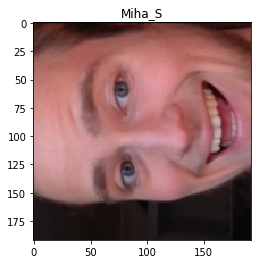

In [14]:
image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path)/255)
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [15]:
n = len(all_image_paths)

x_train_aux = [load_and_preprocess_image(all_image_paths[i]) for i in range(len(all_image_paths))]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n)])
x_train = x_train_aux_2[:int(0.85*n)] / 255   #normalize between 0 and 1
x_test = x_train_aux_2[int(0.85*n):] / 255
print(x_train.shape)
print(x_test.shape)

y_train_aux = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels])
y_train = y_train_aux[:int(0.85*n)]
y_test = y_train_aux[int(0.85*n):]
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(2142, 192, 192, 3)
(378, 192, 192, 3)
(2142, 4)
(378, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[0 0 1 0]


(2142, 4)


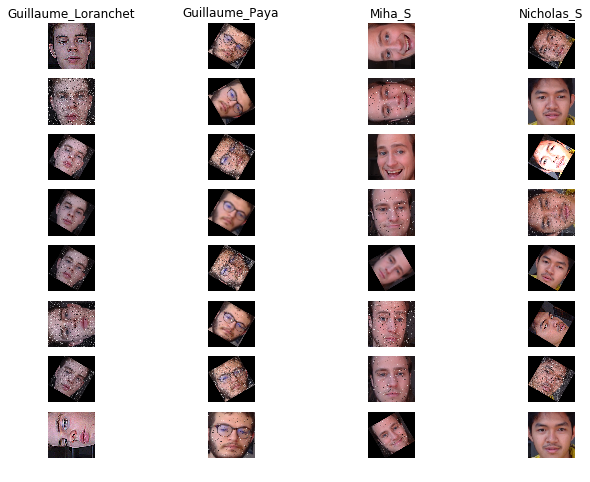

In [16]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    print(categories.shape)
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < len(categories):
            #print(j,i)
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels)

##kNN Model

In [17]:
def euclidean_distance(ima_1,ima_2):
  return np.sqrt(sum(sum(sum((ima_1-ima_2)**2))))

print(euclidean_distance(x_train[0],x_train[1]))

54.86281441706868


In [18]:
def test(ima_test,label):
  print(label)
  x1, x2, x3, x4 = [],[],[],[]
  for i in range(0,100):
    if y_train[i][0]:
      x1.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][1]:
      x2.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][2]:
      x3.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][3]:
      x4.append(euclidean_distance(ima_test,x_train[i]))

  liste = [np.mean(x1),np.mean(x2),np.mean(x3),np.mean(x4)]
  return liste

test(x_test[32],y_test[32])

[0 0 1 0]


[82.25188541924761, 88.09882945763552, 93.31991858300874, 77.34452880205157]

In [0]:
def average(liste):
  return sum(liste)/len(liste)

In [0]:
def clustering(x,y,k):
  nb_pers = len(y[0])  #4
  res = [[] for _ in range(nb_pers)]
  intermediate = [[] for _ in range(nb_pers)]
  
  for i in range(len(x)):
    for j in range(nb_pers):
      if len(intermediate[j]) == k:   #make groups of size k
        res[j].append(average(intermediate[j]))  
        intermediate[j] = []
    for j in range(nb_pers):
      if y[i][j]:   # i-th picture represent the j-th person in labels
        intermediate[j].append(x[i])
  for j in range(nb_pers):
    if len(intermediate[j]) != 0:
      res[j].append(average(intermediate[j])) 
  return res
        

A = clustering(x_train,y_train,100)

In [21]:
def try_mode(liste):
  '''check if there are more than 1 mode'''
  try:
    return mode(liste)
  except StatisticsError:
    return -1
  
B = [1,2,3]
try_mode(B)

-1

In [0]:
A = clustering(x_train,y_train,5)

def kNN(ima_input,A,k):  
  res_aux = {}
  for i in range(len(A)):
    for j in range(len(A[i])):
      res_aux[euclidean_distance(ima_input,A[i][j])] = i
        
  res = [value for (key,value) in sorted(res_aux.items())]   #take only the first k closest element
  #print(res)
  while try_mode(res[:k]) == -1:  #return the most frequent element
    k += 1
  return mode(res[:k])
  
  
def test_knn(A,k):
  res = 0
  for i in range(len(y_test)):
    val = kNN(x_test[i],A,k)
    if y_test[i][val]:
      res += 1
  return res/len(y_test)

#for k in [1,2,3,5,7]:
#  print('k = ',k)
#  print(test_knn(A,k))
#  print('')

#for k in range(30):
#  print(y_test[k])
#  print(kNN(x_test[k],A,10))
  

In [23]:
n = len(y_test)

def test_final():
  for i in [1,2,3,4,5,6,7,8]:
    A = clustering(x_train,y_train,i)
    def test_time():
      print('Cluster of {} elements'.format(i))
      print('Accuracy: ',test_knn(A,2))

    print('Time to predict each picture',timeit.timeit(test_time,number=1)/n,'\n')
    
test_final()

Cluster of 1 elements
Accuracy:  0.9894179894179894
Time to predict each picture 0.822589813322752 

Cluster of 2 elements
Accuracy:  0.9576719576719577
Time to predict each picture 0.41410568568782824 

Cluster of 3 elements
Accuracy:  0.9047619047619048
Time to predict each picture 0.273005588883597 

Cluster of 4 elements
Accuracy:  0.8703703703703703
Time to predict each picture 0.206690111798943 

Cluster of 5 elements
Accuracy:  0.8677248677248677
Time to predict each picture 0.17552989149470988 

Cluster of 6 elements
Accuracy:  0.8703703703703703
Time to predict each picture 0.13829420505291118 

Cluster of 7 elements
Accuracy:  0.7671957671957672
Time to predict each picture 0.12617940976719827 

Cluster of 8 elements
Accuracy:  0.7116402116402116
Time to predict each picture 0.1033868014920608 

